# ELVIS data preprocessing

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [2]:
import fiona
import geopandas as gpd
import pandas as pd

## Identify coastal LiDAR from ELVIS project extents index

In [3]:
path = '/gdata1/projects/coastal/ELVIS/ELVIS_Project_Extents.gpkg'
layers = fiona.listlayers(path)
layers

['public.NSW_100k_Index_57',
 'public.TAS_Project_Index_55',
 'public.DAWE_Project_Index_56',
 'public.VIC_Elevation_Metadata_Index',
 'public.NSW_100k_Index_56',
 'public.QLD_Elevation_Metadata_Index',
 'public.GriffithUniFugro_Project_Index_55',
 'public.GA_Project_Index_54',
 'public.TAS_DEM_Index_2m',
 'public.SA_Elevation_Metadata_Index',
 'public.GriffithUniFugro_Project_Index_54',
 'public.GA_Project_Index_52',
 'public.DAWE_Project_Index_55',
 'public.GA_Project_Index_53',
 'public.NSW_100k_Index_55',
 'public.NSW_DPIE_Elevation_Metadata_Index',
 'public.GriffithUniFugro_Project_Index_56']

In [4]:
out = []

for i in layers:

    project = (
        gpd.read_file(path, layer=i)
        .assign(data_source=i[7:])
        .to_crs("EPSG:4326")
    )

    # Standardise project name
    if "project_raw" in project.columns:
        pass
    elif "project" in project.columns:
        project = project.rename({"project": "project_raw"}, axis=1)
    elif "object_name" in project.columns:
        project = project.rename({"object_name": "project_raw"}, axis=1)
    else:
        pass

    # Drop LAS data if data type exists
    if "data_type" in project.columns:
        project = project.loc[~project.data_type.isin(["las_reflectance", "las_height"])]

    out.append(project[["project_raw", "metadata_url", "data_source", "geometry"]])


In [5]:
# Combine all layers
projects_gdf = pd.concat(out, axis=0)

# Add year data
projects_gdf["year"] = projects_gdf.project_raw.str.extract(r"(\d{4})").astype(float).values
invalid = (projects_gdf.year < 2000) | (projects_gdf.year > 2030)
projects_gdf.loc[invalid, "year"] = (
    projects_gdf.loc[invalid].project_raw.str.extract(r"(\d{4}$)").astype(float).values
)
projects_gdf.loc[projects_gdf.project_raw == 'VICMAP_ELEV_DEM_10M', "year"] = 2021

In [6]:
# Filter to time of interest
projects_gdf = projects_gdf.loc[projects_gdf.year >= 2016]
projects_gdf

,project_raw,metadata_url,data_source,geometry,year
5,CampbellTown2019,NaN,TAS_Project_Index_55,"POLYGON ((147.48252 -41.93795, 147.48245 -41.9...",2019.0
26,Westerway2019,NaN,TAS_Project_Index_55,"POLYGON ((146.80475 -42.66830, 146.80472 -42.6...",2019.0
27,BrontePark2019,NaN,TAS_Project_Index_55,"POLYGON ((146.51605 -42.12709, 146.51598 -42.1...",2019.0
28,CrampsBay2019,NaN,TAS_Project_Index_55,"POLYGON ((146.85538 -41.87583, 146.85536 -41.8...",2019.0
34,Scotia2017,NaN,TAS_Project_Index_55,"POLYGON ((148.02170 -40.94361, 148.02183 -40.9...",2017.0
...,...,...,...,...,...
46,Dalby201811,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((151.41121 -26.74339, 151.41134 -26.7...",2018.0
47,Bundaberg201801,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((152.46377 -25.25236, 152.45384 -25.2...",2018.0
48,Bundaberg201801,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((152.09525 -25.40408, 152.10519 -25.4...",2018.0
49,Bundaberg201801,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((152.14393 -25.54885, 152.16384 -25.5...",2018.0


### Filter to coast

In [7]:
coastline_gdf = gpd.read_file(
    "/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp"
).query("FEAT_CODE == 'coastline'").to_crs("EPSG:4326")

In [8]:
projects_gdf.assign(id=range(0, len(projects_gdf.index)))  # Create temporary ID so we can keep only the first of n duplicates for each row

,project_raw,metadata_url,data_source,geometry,year,id
5,CampbellTown2019,NaN,TAS_Project_Index_55,"POLYGON ((147.48252 -41.93795, 147.48245 -41.9...",2019.0,0
26,Westerway2019,NaN,TAS_Project_Index_55,"POLYGON ((146.80475 -42.66830, 146.80472 -42.6...",2019.0,1
27,BrontePark2019,NaN,TAS_Project_Index_55,"POLYGON ((146.51605 -42.12709, 146.51598 -42.1...",2019.0,2
28,CrampsBay2019,NaN,TAS_Project_Index_55,"POLYGON ((146.85538 -41.87583, 146.85536 -41.8...",2019.0,3
34,Scotia2017,NaN,TAS_Project_Index_55,"POLYGON ((148.02170 -40.94361, 148.02183 -40.9...",2017.0,4
...,...,...,...,...,...,...
46,Dalby201811,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((151.41121 -26.74339, 151.41134 -26.7...",2018.0,1838
47,Bundaberg201801,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((152.46377 -25.25236, 152.45384 -25.2...",2018.0,1839
48,Bundaberg201801,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((152.09525 -25.40408, 152.10519 -25.4...",2018.0,1840
49,Bundaberg201801,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_56,"POLYGON ((152.14393 -25.54885, 152.16384 -25.5...",2018.0,1841


In [9]:
projects_coastal_gdf = (
    projects_gdf.assign(id=range(0, len(projects_gdf.index)))  # Create temporary ID so we can keep only the first of n duplicates for each row
    .sjoin(coastline_gdf, predicate="intersects")
    .groupby("id")
    .first()
    .dissolve("project_raw")
)[["metadata_url", "data_source", "year", "geometry"]]


In [10]:
projects_coastal_gdf

,metadata_url,data_source,year,geometry
project_raw,,,,
AdelaideMetro2018,http://location.sa.gov.au/LMS/Reports/ReportMe...,SA_Elevation_Metadata_Index,2018.0,"POLYGON ((138.72196 -34.69992, 138.71624 -34.7..."
AdelaideMetro2022,http://location.sa.gov.au/LMS/Reports/ReportMe...,SA_Elevation_Metadata_Index,2022.0,"POLYGON ((138.68344 -35.01350, 138.68509 -35.0..."
AnnaBay2018,https://datasets.seed.nsw.gov.au/dataset/marin...,NSW_DPIE_Elevation_Metadata_Index,2018.0,"POLYGON ((152.20370 -32.72146, 152.20373 -32.7..."
Ayr201804,https://griffith-elvis.s3-ap-southeast-2.amazo...,GriffithUniFugro_Project_Index_55,2018.0,"POLYGON ((147.24877 -20.14006, 147.23921 -20.1..."
BatemansBay2018,https://datasets.seed.nsw.gov.au/dataset/marin...,NSW_DPIE_Elevation_Metadata_Index,2018.0,"POLYGON ((150.22733 -35.68666, 150.22736 -35.6..."
...,...,...,...,...
Yuraygir2018,https://datasets.seed.nsw.gov.au/dataset/marin...,NSW_DPIE_Elevation_Metadata_Index,2018.0,"MULTIPOLYGON (((153.38812 -29.88437, 153.38817..."
cann-river-south2020apr13,https://www.land.vic.gov.au/__data/assets/pdf_...,VIC_Elevation_Metadata_Index,2020.0,"MULTIPOLYGON (((149.51735 -37.74769, 149.51720..."
golden-plains2021apr29,https://www.land.vic.gov.au/__data/assets/pdf_...,VIC_Elevation_Metadata_Index,2021.0,"POLYGON ((144.26338 -38.39330, 144.26304 -38.4..."


<Axes: >

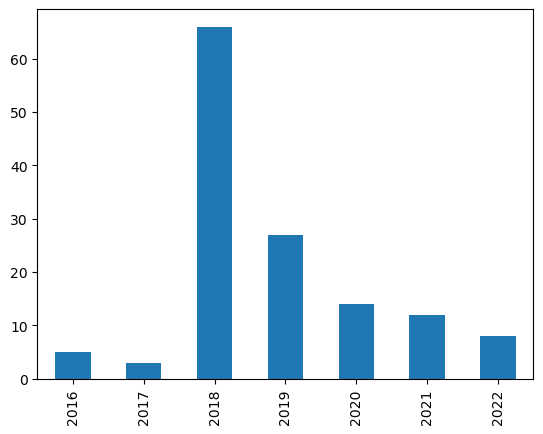

In [11]:
projects_coastal_gdf.year.astype(int).value_counts().sort_index().plot(kind='bar')

### Export:

In [12]:
projects_coastal_gdf["geometry"] = projects_coastal_gdf.geometry.simplify(0.001)
projects_coastal_gdf.to_file("elvis_coastal_projects.geojson")

## Pre-process ELVIS tile indexes to extract S3 paths and project data

In [116]:
# List layers in GeoPackage
path = '/gdata1/projects/coastal/ELVIS/Elvis_DEM_Tile_Extents_NIDEM.gpkg'
layers = fiona.listlayers(path)

# Remove inaccessible Vic data
layers.remove("public.VIC_Tile_Index_55")
layers

['public.NSW-DPIE_Tile_Index_56',
 'public.TAS_DEM_Index_2m',
 'public.QLD_Bathy_Tile_Index_56',
 'public.VIC_DEM_Index_10m',
 'public.GA_Tile_Index_52',
 'public.QLD_Tile_Index_56',
 'public.GriffithUniFugro_Tile_Index_54',
 'public.DAWE_Tile_Index_55',
 'public.TAS_Tile_Index_55',
 'public.SA_Tile_Index_53',
 'public.SA_Tile_Index_54',
 'public.GA_Tile_Index_54',
 'public.GriffithUniFugro_Tile_Index_56',
 'public.GriffithUniFugro_Tile_Index_55',
 'public.QLD_Tile_Index_55',
 'public.NSW_Tile_Index_56',
 'public.NSW_DPIE_Elevation_Metadata_Index']

### Filter to coast

In [117]:
# Load coastline data
coastline_gdf = gpd.read_file(
    "/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp"
).query("FEAT_CODE == 'coastline'").to_crs("EPSG:3577")

# Buffer by 1 km
coastline_gdf["geometry"] = coastline_gdf.buffer(1000).simplify(100)

In [118]:
out_list = []

for i in layers:
    print(i)

    # Read layer
    project_gdf = (
        gpd.read_file(path, layer=i, rows=None)
        .assign(data_source=i[7:])
        .to_crs("EPSG:4326")
    )

    # Get the identifier columns dynamically
    stackable_columns = project_gdf.filter(like="object_url").columns
    id_columns = ["data_source", "geometry"]

    # Melt the DataFrame
    melted_gdf = pd.melt(
        project_gdf,
        id_vars=id_columns,
        value_vars=stackable_columns,
        var_name="resolution",
        value_name="s3_url",
    )

    # Get resolution
    melted_gdf["resolution"] = (
        melted_gdf.resolution.str.replace("object_url", "")
        .str.replace("dem", "")
        .str.strip("_")
    )

    # Drop rows with NaN values in 'value' column, and where file
    # format is not GeoTIFF
    melted_gdf = melted_gdf.dropna(subset=["s3_url"])
    melted_gdf = melted_gdf.loc[melted_gdf.s3_url.str.endswith(".tif")]

    # Extract project name and date
    file_names = melted_gdf.s3_url.str.split("/").str[-1]
    melted_gdf[["project", "year"]] = file_names.str.extract("^(.*?)(\d{4})")
    melted_gdf["project"] = melted_gdf["project"].str.strip("_")

    # Convert to vsis3 paths, handling differently formatted S3 URLs
    melted_gdf["vsis3_path"] = (
        melted_gdf.s3_url.str.replace("https://", "/vsis3/")
        .str.replace("s3-ap-southeast-2.amazonaws.com", "")
        .str.replace("//", "/", regex=False)
        .str.replace("./", "/", regex=False)
    )

    # Dissolve duplicate columns
    melted_gdf = melted_gdf.dissolve(
        by=["data_source", "project", "year", "resolution", "s3_url", "vsis3_path"],
        as_index=False,
    )

    # CLip to coastline
    clipped_gdf = melted_gdf.clip(mask=coastline_gdf.to_crs(crs=melted_gdf.crs))

    # Append to file
    out_list.append(clipped_gdf)


# Combine into a single layer
combined_gdf = pd.concat(out_list, ignore_index=True)
combined_gdf.to_file("elvis_preprocessed.geojson")

public.NSW-DPIE_Tile_Index_56
public.TAS_DEM_Index_2m
public.QLD_Bathy_Tile_Index_56
public.VIC_DEM_Index_10m
public.GA_Tile_Index_52
public.QLD_Tile_Index_56
public.GriffithUniFugro_Tile_Index_54
public.DAWE_Tile_Index_55
public.TAS_Tile_Index_55
public.SA_Tile_Index_53
public.SA_Tile_Index_54
public.GA_Tile_Index_54
public.GriffithUniFugro_Tile_Index_56
public.GriffithUniFugro_Tile_Index_55
public.QLD_Tile_Index_55
public.NSW_Tile_Index_56
public.NSW_DPIE_Elevation_Metadata_Index


In [175]:
combined_gdf = pd.concat(out_list, ignore_index=True)
combined_gdf.to_file("elvis_preprocessed.geojson")

# with pd.option_context("display.max_rows", 100, "display.max_colwidth", 200):
#     display(
#         combined_gdf[
#             ["data_source", "project", "year", "resolution", "s3_url", "vsis3_path", "geometry"]
#         ]
#     )

/tmp/ipykernel_232/2204249781.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("s3-ap-southeast-2.amazonaws.com", "")


In [174]:
combined_gdf.query("s3_url == 'https://qld-elvis.s3-ap-southeast-2.amazonaws.com/elevation/1m-dem/z56/Moreton_Bay_2018_LGA/Moreton_Bay_2018_LGA_SW_505000_6978000_1k_DEM_1m.tif'").s3_url.str.replace("https://", "/vsis3/").str.replace("s3-ap-southeast-2.amazonaws.com", "").str.replace("//", "/", regex=False).str.replace("./", "/", regex=False)



/tmp/ipykernel_232/2394436667.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_gdf.query("s3_url == 'https://qld-elvis.s3-ap-southeast-2.amazonaws.com/elevation/1m-dem/z56/Moreton_Bay_2018_LGA/Moreton_Bay_2018_LGA_SW_505000_6978000_1k_DEM_1m.tif'").s3_url.str.replace("https://", "/vsis3/").str.replace("s3-ap-southeast-2.amazonaws.com", "").str.replace("//", "/", regex=False).str.replace("./", "/", regex=False)


1235    /vsis3/qld-elvis/elevation/1m-dem/z56/Moreton_...
Name: s3_url, dtype: object

In [120]:
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', 300):
    display(combined_gdf.groupby("data_source").first().s3_url)

data_source
DAWE_Tile_Index_55                                                          https://dawe-elvis.s3-ap-southeast-2.amazonaws.com/elevation/50cm-dem/z55/StyxLidar2020/StyxLidar2020-DEM-0_5_7707503_55_0001_0001.tif
GA_Tile_Index_52                                                            https://ga-elvis.s3-ap-southeast-2.amazonaws.com/elevation/1m-dem/ausgeoid/z52/KimberleyEast2017-DEM-GRID-001_5128314_52_0002_0002.tif
GA_Tile_Index_54                                                            https://ga-elvis.s3-ap-southeast-2.amazonaws.com/elevation/1m-dem/ausgeoid/z54/NirrandaLidar2016-DEM-GRID-001_6605724_54_0002_0002.tif
GriffithUniFugro_Tile_Index_54       https://griffith-elvis.s3-ap-southeast-2.amazonaws.com/elevation/50cm-dem/z54/RemoteCapeMainland201808_Cycle6/RemoteCapeMainland201808-DEM-GRID-50cm_7548584_54_0001_0001.tif
GriffithUniFugro_Tile_Index_55                       https://griffith-elvis.s3-ap-southeast-2.amazonaws.com/elevation/50cm-dem/z55/StLawrence201

In [105]:
# https://s3.ap-southeast-2.amazonaws.com/tas-elvis/elevation/2m-dem/z55/mosaics/Tasmania_Statewide_2m_DEM_14-08-2021.tif
# https://tas-elvis.s3-ap-southeast-2.amazonaws.com/elevation/50cm-dem/z55/SouthCoast2021/SouthCoast2021-DEM-50cm_4695177_GDA2020_55.tif
# https://cip-data-archive.s3-ap-southeast-2.amazonaws.com/2020-21/cep24-2020-21_golden-plains/external/epsg7855/golden-plains/regular_surface/dem_unmerged/cog/e259n5746_golden-plains_2021jul11_dem50cm_v10cm_epsg7855.tif

0        zip
1        zip
2        zip
3        zip
4        zip
        ... 
17935    tif
17936    tif
17937    tif
17938    tif
17939    tif
Name: s3_url, Length: 17940, dtype: object

In [162]:
combined_gdf.loc[combined_gdf.year.astype(int) >= 2023]   #.data_source.unique()   #.to_file("elvis_preprocessed.geojson")

,data_source,project,year,resolution,s3_url,geometry,vsis3_path


In [161]:
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', 300):
    display(combined_gdf.query("data_source=='NSW-DPIE_Tile_Index_56'"))

,data_source,project,year,resolution,s3_url,geometry,vsis3_path
